<a href="https://colab.research.google.com/github/JohnPPinto/Deep-Learning-Projects-Notebooks/blob/main/Toxic_Comment_Classification_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Comment Classification Using PyTorch

**Project Description:**

This project is part of the [kaggle competition](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview), provided by Conversation AI team founded by Jigsaw and Google. This competition is created to study about the negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion).

In this competition, we're challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate.

**Project Dataset**

The dataset that will be used is of comments from Wikipedia’s talk page edits. Which have been labeled by human raters for toxic behavior. The types of toxicity are:

* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

**Project Objective**

You must create a model which predicts a probability of each type of toxicity for each comment.

## Downloading the Data

In [ ]:
!pip install -q lightning

In [ ]:
import os
import re
import shutil
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import spacy
import torch
import torch.nn as nn
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
# Downloading the data from kaggle
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
data_dirpath = 'data'

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p $data_dirpath

jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extracting the data
shutil.unpack_archive('data/jigsaw-toxic-comment-classification-challenge.zip', data_dirpath)

## Preprocessing the Data

In [ ]:
# Reading the data
raw_train_df = pd.read_csv('data/train.csv.zip')
test_df = pd.read_csv('data/test.csv.zip')
test_labels_df = pd.read_csv('data/test_labels.csv.zip')
sample_sub_df = pd.read_csv('data/sample_submission.csv.zip')

In [ ]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
raw_train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
test_labels_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [ ]:
sample_sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
# Getting all the class names
classes = raw_train_df.columns[2:].tolist()
classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Checking the data ratio for all the classes
[raw_train_df[col].value_counts(normalize=True) for col in classes]

[0    0.904156
 1    0.095844
 Name: toxic, dtype: float64,
 0    0.990004
 1    0.009996
 Name: severe_toxic, dtype: float64,
 0    0.947052
 1    0.052948
 Name: obscene, dtype: float64,
 0    0.997004
 1    0.002996
 Name: threat, dtype: float64,
 0    0.950636
 1    0.049364
 Name: insult, dtype: float64,
 0    0.991195
 1    0.008805
 Name: identity_hate, dtype: float64]

### Building the Vocabulary

In [ ]:
# Taking a sample data
sample_text = raw_train_df.comment_text.values[42]
sample_text

"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [ ]:
# Tokenizing sample data using torchtext
torch_tokenizer = get_tokenizer('basic_english')
sample_text2token = torch_tokenizer(sample_text)
print(sample_text2token)

['you', 'are', 'gay', 'or', 'antisemmitian', '?', 'archangel', 'white', 'tiger', 'meow', '!', 'greetingshhh', '!', 'uh', ',', 'there', 'are', 'two', 'ways', ',', 'why', 'you', 'do', 'erased', 'my', 'comment', 'about', 'ww2', ',', 'that', 'holocaust', 'was', 'brutally', 'slaying', 'of', 'jews', 'and', 'not', 'gays/gypsys/slavs/anyone', '.', '.', '.', '1', '-', 'if', 'you', 'are', 'anti-semitian', ',', 'than', 'shave', 'your', 'head', 'bald', 'and', 'go', 'to', 'the', 'skinhead', 'meetings', '!', '2', '-', 'if', 'you', 'doubt', 'words', 'of', 'the', 'bible', ',', 'that', 'homosexuality', 'is', 'a', 'deadly', 'sin', ',', 'make', 'a', 'pentagram', 'tatoo', 'on', 'your', 'forehead', 'go', 'to', 'the', 'satanistic', 'masses', 'with', 'your', 'gay', 'pals', '!', '3', '-', 'first', 'and', 'last', 'warning', ',', 'you', 'fucking', 'gay', '-', 'i', 'won', "'", 't', 'appreciate', 'if', 'any', 'more', 'nazi', 'shwain', 'would', 'write', 'in', 'my', 'page', '!', 'i', 'don', "'", 't', 'wish', 'to', 

In [ ]:
# Tokenizing sample data using spacy
spacy_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
sample_text2token = spacy_tokenizer(sample_text)
print(sample_text2token)

['You', 'are', 'gay', 'or', 'antisemmitian', '?', '\n\n', 'Archangel', 'WHite', 'Tiger', '\n\n', 'Meow', '!', 'Greetingshhh', '!', '\n\n', 'Uh', ',', 'there', 'are', 'two', 'ways', ',', 'why', 'you', 'do', 'erased', 'my', 'comment', 'about', 'WW2', ',', 'that', 'holocaust', 'was', 'brutally', 'slaying', 'of', 'Jews', 'and', 'not', 'gays', '/', 'Gypsys', '/', 'Slavs', '/', 'anyone', '...', '\n\n', '1', '-', 'If', 'you', 'are', 'anti', '-', 'semitian', ',', 'than', 'shave', 'your', 'head', 'bald', 'and', 'go', 'to', 'the', 'skinhead', 'meetings', '!', '\n\n', '2', '-', 'If', 'you', 'doubt', 'words', 'of', 'the', 'Bible', ',', 'that', 'homosexuality', 'is', 'a', 'deadly', 'sin', ',', 'make', 'a', 'pentagram', 'tatoo', 'on', 'your', 'forehead', 'go', 'to', 'the', 'satanistic', 'masses', 'with', 'your', 'gay', 'pals', '!', '\n\n', '3', '-', 'First', 'and', 'last', 'warning', ',', 'you', 'fucking', 'gay', '-', 'I', 'wo', "n't", 'appreciate', 'if', 'any', 'more', 'nazi', 'shwain', 'would', 'w

In [ ]:
# Loading the language in spacy
nlp = spacy.load('en_core_web_sm', enable=['tagger', 'morphologizer', 'attribute_ruler', 'lemmatizer'])

# Creating a function that will preprocess the data
# using spacy, removing punctuation, spaces and
# stop words, also filtering out alphabetic characters
# and return the lemma of the word
def spacy_tokenizer(dataset, verbose=True):
    tokenized_dataset = []
    for doc in tqdm(nlp.pipe(dataset),
                    total=len(dataset),
                    disable=not(verbose)):
        tokenized_dataset.append([token.lemma_.lower() for token in doc if \
                                  not token.is_punct and \
                                  not token.is_space and \
                                  not token.is_stop and \
                                  token.is_alpha])
    return tokenized_dataset

In [ ]:
%%time
# Applying the new spacy tokenizer function on the smaple data
sample_text2token = spacy_tokenizer([sample_text])
print(sample_text2token[0])

  0%|          | 0/1 [00:00<?, ?it/s]

['gay', 'antisemmitian', 'archangel', 'white', 'tiger', 'meow', 'greetingshhh', 'uh', 'ways', 'erased', 'comment', 'holocaust', 'brutally', 'slaying', 'jews', 'gays', 'gypsys', 'slavs', 'anti', 'semitian', 'shave', 'head', 'bald', 'skinhead', 'meetings', 'doubt', 'words', 'bible', 'homosexuality', 'deadly', 'sin', 'pentagram', 'tatoo', 'forehead', 'satanistic', 'masses', 'gay', 'pals', 'warning', 'fucking', 'gay', 'wo', 'appreciate', 'nazi', 'shwain', 'write', 'page', 'wish', 'talk', 'anymore', 'beware', 'dark']
CPU times: user 30 ms, sys: 1.01 ms, total: 31 ms
Wall time: 53.3 ms


In [ ]:
%%time
# Tokenizing all the comments in the raw training data
comment_tokens = spacy_tokenizer(raw_train_df.comment_text.to_list())
comment_tokens[:10]

  0%|          | 0/159571 [00:00<?, ?it/s]

CPU times: user 6min 25s, sys: 2.37 s, total: 6min 27s
Wall time: 6min 42s


[['explanation',
  'edits',
  'username',
  'hardcore',
  'metallica',
  'fan',
  'reverted',
  'vandalisms',
  'closure',
  'gas',
  'voted',
  'new',
  'york',
  'dolls',
  'fac',
  'remove',
  'template',
  'talk',
  'page',
  'retired'],
 ['matches',
  'background',
  'colour',
  'seemingly',
  'stuck',
  'thanks',
  'talk',
  'january',
  'utc'],
 ['hey',
  'man',
  'trying',
  'edit',
  'war',
  'guy',
  'constantly',
  'removing',
  'relevant',
  'information',
  'talking',
  'edits',
  'instead',
  'talk',
  'page',
  'care',
  'formatting',
  'actual',
  'info'],
 ['real',
  'suggestions',
  'improvement',
  'wondered',
  'section',
  'statistics',
  'later',
  'subsection',
  'types',
  'accidents',
  'think',
  'references',
  'need',
  'tidying',
  'exact',
  'format',
  'ie',
  'date',
  'format',
  'etc',
  'later',
  'preferences',
  'formatting',
  'style',
  'references',
  'want',
  'let',
  'know',
  'appears',
  'backlog',
  'articles',
  'review',
  'guess',
  'del

In [ ]:
# Generating a vocab from the raw training data
VOCAB_SIZE = 10000
unk_token = '<unk>'
pad_token = '<pad>'

vocab = build_vocab_from_iterator(comment_tokens,
                                  specials=[unk_token, pad_token],
                                  max_tokens=VOCAB_SIZE)

In [ ]:
# Checking the index of unkown token
vocab[unk_token], vocab[pad_token]

(0, 1)

In [ ]:
# Setting the unknown token as default
vocab.set_default_index(vocab[unk_token])

In [ ]:
# Coverting the tokenized sample into vocab indices
sample_token2indices = vocab.lookup_indices(sample_text2token[0])
print(sample_token2indices)

[248, 0, 0, 414, 5183, 0, 0, 4115, 920, 3573, 70, 2053, 0, 0, 492, 6361, 0, 7230, 322, 0, 0, 631, 5829, 0, 6650, 572, 210, 1642, 3485, 8574, 4844, 0, 0, 0, 0, 6265, 248, 0, 288, 203, 248, 286, 391, 830, 0, 150, 3, 307, 5, 955, 7797, 1743]


In [ ]:
# Converting the tokenized sample indices back to vocab tokens.
sample_indices2tokens = vocab.lookup_tokens(sample_token2indices)
print(sample_text)
print(sample_indices2tokens)

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
['gay', '<unk>', '<unk>', 'white', 'tiger', '<unk>', '<unk>', 'uh', 'ways', 'erased', 'comment', 'holocaust', '<unk>', '<unk>', 'jews', 'gays', '<unk>', 'slavs', 'anti', '<unk>', '<unk>', 'head', 'bald', '<unk>', 'meetings', 'doubt', 'words', 'bible', 'homosexuality', 'deadly', 'sin', '<unk>', '<unk>', '<unk>', '<unk>', 'masses', 'gay', '<unk>', 'wa

### Creating Training, Validation and Test Dataset

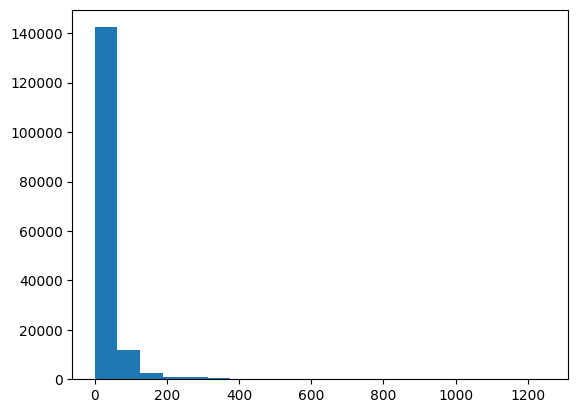

In [ ]:
# Understanding the length of tokens in the data
plt.hist(list(map(len, comment_tokens)), 20);

In [ ]:
# Creating a function that adds padding token to the data
def pad_tokens(data, pad_token, max_length):
    # Tokens in
    if len(data) >= max_length:
        return data[:max_length]
    else:
        return data + [pad_token] * (max_length - len(data))

In [ ]:
# Creating a class for pytorch dataset
class ToxicCommentDataset(Dataset):
    def __init__(self,
                 data,
                 max_length,
                 verbose=False,
                 is_test=False):
        self.data = data
        self.max_length = max_length
        self.verbose = verbose
        self.is_test = is_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = [self.data.comment_text.values[index]]
        tokens = spacy_tokenizer(text, self.verbose)[0]
        input = torch.tensor(pad_tokens(vocab.lookup_indices(tokens),
                                        vocab[pad_token],
                                        self.max_length))
        if self.is_test:
            target = torch.tensor([0, 0, 0, 0, 0, 0],
                                  dtype=torch.float)
        else:
            target = torch.tensor(self.data[classes].values[index],
                                  dtype=torch.float)
        return input, target

In [ ]:
# Setting max length and creating the dataset
MAX_LENGTH = 150
raw_train_dataset = ToxicCommentDataset(data=raw_train_df,
                                        max_length=MAX_LENGTH,
                                        verbose=False,
                                        is_test=False)

In [ ]:
raw_train_dataset[42]

(tensor([ 248,    0,    0,  414, 5183,    0,    0, 4115,  920, 3573,   70, 2053,
            0,    0,  492, 6361,    0, 7230,  322,    0,    0,  631, 5829,    0,
         6650,  572,  210, 1642, 3485, 8574, 4844,    0,    0,    0,    0, 6265,
          248,    0,  288,  203,  248,  286,  391,  830,    0,  150,    3,  307,
            5,  955, 7797, 1743,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [ ]:
print(vocab.lookup_tokens(raw_train_dataset[42][0].tolist()))

['gay', '<unk>', '<unk>', 'white', 'tiger', '<unk>', '<unk>', 'uh', 'ways', 'erased', 'comment', 'holocaust', '<unk>', '<unk>', 'jews', 'gays', '<unk>', 'slavs', 'anti', '<unk>', '<unk>', 'head', 'bald', '<unk>', 'meetings', 'doubt', 'words', 'bible', 'homosexuality', 'deadly', 'sin', '<unk>', '<unk>', '<unk>', '<unk>', 'masses', 'gay', '<unk>', 'warning', 'fucking', 'gay', 'wo', 'appreciate', 'nazi', '<unk>', 'write', 'page', 'wish', 'talk', 'anymore', 'beware', 'dark', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

In [ ]:
# Spliting the raw dataset into training and validation split
VAL_LENGTH = 0.25 # 25 percent of the dataset

train_dataset, val_dataset = random_split(raw_train_dataset,
                                          [1 - VAL_LENGTH, VAL_LENGTH])

len(train_dataset), len(val_dataset), len(raw_train_dataset)

(119679, 39892, 159571)

In [ ]:
# Converting the test dataframe into test dataset
test_dataset = ToxicCommentDataset(data=test_df,
                                   max_length=150,
                                   verbose=False,
                                   is_test=True)
len(test_dataset)

153164

In [ ]:
test_dataset[0]

(tensor([2151,  524, 8594,  397,    0,  344, 6059, 1173,    0,  524, 4240, 1507,
            0,  414, 6104, 4387,  242,  454,    0, 8594,  397, 3633, 2403,  420,
          222,   99,    0,  152,    0,   87,    0,    6,    0, 1546, 2077,  414,
         2410,   79,   39,   13,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [ ]:
test_df.comment_text[0]

"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"

In [ ]:
print(spacy_tokenizer([test_df.comment_text[0]], False)[0])

['yo', 'bitch', 'ja', 'rule', 'succesful', 's', 'hating', 'sad', 'mofuckas', 'bitch', 'slap', 'ur', 'pethedic', 'white', 'faces', 'kiss', 'ass', 'guys', 'sicken', 'ja', 'rule', 'pride', 'da', 'music', 'man', 'nt', 'diss', 'shit', 'nothin', 'wrong', 'bein', 'like', 'tupac', 'brother', 'fuckin', 'white', 'boys', 'things', 'right', 'time']


In [ ]:
print(vocab.lookup_tokens(test_dataset[0][0].tolist()))

['yo', 'bitch', 'ja', 'rule', '<unk>', 's', 'hating', 'sad', '<unk>', 'bitch', 'slap', 'ur', '<unk>', 'white', 'faces', 'kiss', 'ass', 'guys', '<unk>', 'ja', 'rule', 'pride', 'da', 'music', 'man', 'nt', '<unk>', 'shit', '<unk>', 'wrong', '<unk>', 'like', '<unk>', 'brother', 'fuckin', 'white', 'boys', 'things', 'right', 'time', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad

### Creating PyTorch Dataloaders

In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=os.cpu_count(),
                          pin_memory=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE * 2,
                        num_workers=os.cpu_count(),
                        pin_memory=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE*2,
                         num_workers=os.cpu_count(),
                         pin_memory=True)

In [ ]:
input, target = next(iter(train_loader))
print(f'Training input shape: {input.shape} and target shape: {target.shape}')

Training input shape: torch.Size([256, 150]) and target shape: torch.Size([256, 6])


In [ ]:
input, target = next(iter(val_loader))
print(f'Validation input shape: {input.shape} and target shape: {target.shape}')

Validation input shape: torch.Size([512, 150]) and target shape: torch.Size([512, 6])


In [ ]:
a = nn.Embedding(VOCAB_SIZE, 256, 1)
print(a(input).shape)
b = nn.LSTM(input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True)
bout1, bout2 = b(a(input))
c = nn.LSTM(input_size=256,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True)
cout1, cout2 = c(b(a(input))[0])
print(nn.Dropout(0.1)(cout1).shape)
print(nn.ReLU()(nn.Linear(128, 64)(nn.Dropout(0.1)(cout1))[:,-1,:]).shape)

torch.Size([512, 150, 256])
torch.Size([512, 150, 128])
torch.Size([512, 64])


## Building an RNN Model

In [ ]:
# Building the model using pytorch lightning module
class ToxicCommentModel(pl.LightningModule):
    def __init__(self, learning_rate):
        super().__init__()
        self.emb_layer = nn.Embedding(num_embeddings=VOCAB_SIZE,
                                      embedding_dim=256,
                                      padding_idx=1)
        self.bi_lstm1 = nn.LSTM(input_size=256,
                                      hidden_size=128,
                                      num_layers=1,
                                      batch_first=True,
                                      bidirectional=True)
        self.bi_lstm2 = nn.LSTM(input_size=256,
                                      hidden_size=64,
                                      num_layers=1,
                                      batch_first=True,
                                      bidirectional=True)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(64, 6)
        self.learning_rate = learning_rate
        self.validation_step_outputs = []

    def forward(self, x):
        x = self.emb_layer(x)
        x, _ = self.bi_lstm1(x)
        x, _ = self.bi_lstm2(x)
        x = self.dropout1(x)
        x = self.relu(self.linear1(x))[:,-1,:]
        x = self.dropout2(x)
        return self.linear2(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.binary_cross_entropy_with_logits(logits, targets)
        self.log("train_loss",
                 loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.binary_cross_entropy_with_logits(logits, targets)
        self.log('val_loss', loss)
        self.validation_step_outputs.append(loss)
        return loss.item()

    def on_validation_epoch_end(self):
        loss = torch.mean(torch.stack(self.validation_step_outputs)).item()
        print(f'Epoch: {self.current_epoch} | Loss: {loss:.4f}')
        self.validation_step_outputs.clear()

    def predict_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        probs = torch.sigmoid(logits)
        return probs

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.learning_rate)

In [ ]:
model = ToxicCommentModel(learning_rate=1e-3)
model

ToxicCommentModel(
  (emb_layer): Embedding(10000, 256, padding_idx=1)
  (bi_lstm1): LSTM(256, 128, batch_first=True, bidirectional=True)
  (bi_lstm2): LSTM(256, 64, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=64, out_features=6, bias=True)
)

## Training and Evaluating the Model

In [ ]:
# Creating a trainer using pytorch lightning
EPOCHS = 3
trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Creating a tuner that takes the trainer and helps in finding a learning rate
tuner = Tuner(trainer)
tuner.lr_find(model, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch: 0 | Loss: 0.6904


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003311311214825908
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003311311214825908
INFO: Restoring states from the checkpoint path at /content/.lr_find_e8df5749-5ebd-4b41-80ae-af32a8563ae8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_e8df5749-5ebd-4b41-80ae-af32a8563ae8.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_e8df5749-5ebd-4b41-80ae-af32a8563ae8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_e8df5749-5ebd-4b41-80ae-af32a8563ae8.ckpt


In [ ]:
# Best learning rate by tuner
model.learning_rate

0.003311311214825908

In [ ]:
# Fitting the model with the use of trainer
trainer.fit(model, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params
----------------------------------------
0 | emb_layer | Embedding | 2.6 M 
1 | bi_lstm1  | LSTM      | 395 K 
2 | bi_lstm2  | LSTM      | 164 K 
3 | dropout1  | Dropout   | 0     
4 | linear1   | Linear    | 8.3 K 
5 | relu      | ReLU      | 0     
6 | dropout2  | Dropout   | 0     
7 | linear2   | Linear    | 390   
----------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.515    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | emb_layer | Embedding | 2.6 M 
1 | bi_lstm1  | LSTM      | 395 K 
2 | bi_lstm2  | LSTM      | 164 K 
3 | dropout1  | Dropout   | 0     
4 | linear1   | Linear    | 8.3 K 
5 | relu      | ReLU      | 0     
6

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.6904


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.1429


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.0669


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch: 2 | Loss: 0.0544


## Model Prediction and Submission

In [ ]:
# Checking the test dataloader
next(iter(test_loader))

[tensor([[2151,  524, 8594,  ...,    1,    1,    1],
         [ 936,  213,  418,  ...,    1,    1,    1],
         [  20,    0,    0,  ...,    1,    1,    1],
         ...,
         [  49,  116, 1290,  ...,    1,    1,    1],
         [3401,  337,    6,  ...,    1,    1,    1],
         [  61, 4500, 2282,  ...,    1,    1,    1]]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]])]

In [ ]:
next(iter(test_loader))[0].shape, next(iter(test_loader))[1].shape

(torch.Size([512, 150]), torch.Size([512, 6]))

In [ ]:
# Predicting the test dataset using the trainer
test_prediction = trainer.predict(model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Test prediction in batch format
len(test_prediction)

300

In [ ]:
# Transforming from batch to sequence
test_prediction = torch.cat(test_prediction)
test_prediction.shape

torch.Size([153164, 6])

In [ ]:
test_prediction[0]

tensor([0.9825, 0.2395, 0.8961, 0.0474, 0.7576, 0.1459])

In [ ]:
# Getting the probabilities for every label
test_probabilities = torch.sigmoid(test_prediction)
test_probabilities[:5]

tensor([[0.7276, 0.5596, 0.7101, 0.5119, 0.6808, 0.5364],
        [0.5012, 0.5000, 0.5001, 0.5000, 0.5001, 0.5000],
        [0.5259, 0.5001, 0.5041, 0.5006, 0.5043, 0.5007],
        [0.5010, 0.5000, 0.5001, 0.5000, 0.5001, 0.5000],
        [0.5077, 0.5000, 0.5007, 0.5001, 0.5008, 0.5001]])

In [ ]:
# Creating a dataframe for kaggle submission
submission_df = test_df[['id']]
submission_df

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb
...,...
153159,fffcd0960ee309b5
153160,fffd7a9a6eb32c16
153161,fffda9e8d6fafa9e
153162,fffe8f1340a79fc2


In [ ]:
submission_df[classes] = test_probabilities.detach().cpu().numpy()
submission_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.727606,0.559601,0.710139,0.511856,0.680826,0.536413
1,0000247867823ef7,0.501171,0.500000,0.500065,0.500008,0.500072,0.500008
2,00013b17ad220c46,0.525893,0.500135,0.504058,0.500567,0.504336,0.500733
3,00017563c3f7919a,0.500967,0.500000,0.500051,0.500006,0.500056,0.500006
4,00017695ad8997eb,0.507666,0.500013,0.500749,0.500094,0.500810,0.500111
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.584636,0.501177,0.521213,0.502524,0.522473,0.504008
153160,fffd7a9a6eb32c16,0.533928,0.500188,0.505462,0.500701,0.505920,0.500974
153161,fffda9e8d6fafa9e,0.502195,0.500002,0.500149,0.500019,0.500164,0.500021
153162,fffe8f1340a79fc2,0.507506,0.500012,0.500715,0.500088,0.500775,0.500104


In [ ]:
submission_df.to_csv('submission.csv', index=None)

# Submitting on kaggle gives a score of "Score: 0.95589".